# load the trajectory dataset

In [1]:
%matplotlib inline
import h5py
import numpy as np
from libero.lifelong.datasets import *
from libero.libero.utils.dataset_utils import get_dataset_info
from IPython.display import HTML
import imageio
from libero.libero import benchmark, get_libero_path, set_libero_default_path
import os
from termcolor import colored
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
from libero.lifelong.models import *
from libero.lifelong.utils import *

In [2]:
model_path = '/home/ruiqi/projects/meta_adapt/scripts/experiments/LIBERO_OBJECT/PreTrainMultitask/BCViLTPolicy_seed10000/run_009/multitask_model_ep10.pth'
checkpoint = torch.load(model_path)
sd = checkpoint['state_dict']
cfg = checkpoint['cfg']
model = get_policy_class(cfg.policy.policy_type)(cfg, cfg.shape_meta)
model.load_state_dict(sd)

<All keys matched successfully>

In [3]:
datasets_default_path = get_libero_path("datasets")
benchmark_dict = benchmark.get_benchmark_dict()
benchmark_instance = benchmark_dict["libero_object"]()
num_tasks = benchmark_instance.get_num_tasks()
demo_files = [os.path.join(datasets_default_path, benchmark_instance.get_task_demonstration(i)) for i in
              range(num_tasks)]
for demo_file in demo_files:
    if not os.path.exists(demo_file):
        print(colored(f"[error] demo file {demo_file} cannot be found. Check your paths", "red"))

[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [4]:
def fetch_dataset(task_id, traj_id):
    example_demo_file = demo_files[task_id]
    modaility = {'rgb': ['agentview_rgb', 'eye_in_hand_rgb'],
                 'depth': [],
                 'low_dim': ['gripper_states', 'joint_states']}

    task_dataset, shape_meta = get_dataset(
        dataset_path=example_demo_file,
        obs_modality=modaility,
        initialize_obs_utils=True,
        seq_len=1,
    )
    descriptions = []
    task_description = benchmark_instance.get_task(task_id).language
    descriptions.append(task_description)
    task_embs = get_task_embs(cfg, descriptions)

    traj_data = task_dataset.get_trajectory_at_index(traj_id)
    agentview_data = traj_data['obs']['agentview_rgb']
    eye_in_hand_rgb_data = traj_data['obs']['eye_in_hand_rgb']

    # load the agent view list
    agentview_data_list = []
    agentview_data_list.append(torch.from_numpy(agentview_data[0]))
    for i in range(1, len(agentview_data) - 1, 10):
        agentview_data_list.append(torch.from_numpy(agentview_data[i]))
    agentview_data_list.append(torch.from_numpy(agentview_data[-1]))

    # load the eye in hand view list
    eye_in_hand_data_list = []
    eye_in_hand_data_list.append(torch.from_numpy(eye_in_hand_rgb_data[0]))
    for i in range(1, len(eye_in_hand_rgb_data) - 1, 10):
        eye_in_hand_data_list.append(torch.from_numpy(eye_in_hand_rgb_data[i]))
    eye_in_hand_data_list.append(torch.from_numpy(eye_in_hand_rgb_data[-1]))
    return task_embs, agentview_data_list, eye_in_hand_data_list

# load the model and fetch the att maps

In [5]:
def construct_data(task_emb, agent_view_im, eye_in_hand_im):
    data = {}
    data['obs'] = {}
    data['obs']['agentview_rgb'] = agent_view_im[None, None, :]
    data['obs']['eye_in_hand_rgb'] = eye_in_hand_im[None, None, :]
    data['task_emb'] = task_emb[None, :]
    return data

# deal with the att maps 

In [6]:
def show_att_im(data, model):
    att_maps = model.get_spatial_summary(data)
    att_maps_all_layer = []
    for i in range(len(att_maps)):
        att_maps_all_layer.append(att_maps[i])
    att_mat = torch.stack(att_maps_all_layer).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])

    v = joint_attentions[-1]

    # get the att of the spatial summary token (index 0) over all other tokens
    agentview_att = v[0, 1:257]
    agentview_att = agentview_att / agentview_att.sum()
    # print(agentview_att.sum())
    eye_in_hand_att = v[0, 257:257 + 256]
    eye_in_hand_att = eye_in_hand_att / eye_in_hand_att.sum()
    grid_size = 16

    im_agentview = data['obs']['agentview_rgb'][0, 0, :].numpy().transpose(1, 2, 0)
    im_eye_in_hand = data['obs']['eye_in_hand_rgb'][0, 0, :].numpy().transpose(1, 2, 0)

    mask_agentview = agentview_att.reshape(grid_size, grid_size).detach().numpy()
    mask_agentview = cv2.resize(mask_agentview / mask_agentview.max(), im_agentview.shape[:-1])[..., np.newaxis]

    mask_eye_in_hand = eye_in_hand_att.reshape(grid_size, grid_size).detach().numpy()
    mask_eye_in_hand = cv2.resize(mask_eye_in_hand / mask_eye_in_hand.max(), im_eye_in_hand.shape[:-1])[..., np.newaxis]

    masked_im_a = im_agentview * mask_agentview
    masked_im_e = im_eye_in_hand * mask_eye_in_hand
    return masked_im_a[::-1], masked_im_e[::-1]


In [7]:
def show_att_images(images_list, save_flag=False, view='a'):
    # Define grid size (e.g., 3 rows and 4 columns)
    rows = 3
    cols = 6

    # Create a figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot each image in the grid
    for i, ax in enumerate(axes):
        if i < len(images_list):
            ax.imshow(images_list[i])
        ax.axis('off')  # Turn off axis

    # Adjust spacing
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    if not save_flag:
        # Show the plot
        plt.show()
    else:
        plt.savefig(f't_{task_id}_d_{traj_id}_{view}.png', dpi=300, bbox_inches='tight')


In [8]:
def save_att_maps(task_id, traj_id):
    task_embs, agentview_data_list, eye_in_hand_data_list = fetch_dataset(task_id, traj_id)
    agent_att_list = []
    eye_att_list = []
    for i in range(len(agentview_data_list)):
        temp = construct_data(task_embs, agentview_data_list[i], eye_in_hand_data_list[i])
        im_a, im_e = show_att_im(temp, model)
        agent_att_list.append((im_a * 255).astype(np.uint8))
        eye_att_list.append((im_e * 255).astype(np.uint8))

    show_att_images(agent_att_list, save_flag=True, view='a')
    show_att_images(eye_att_list, save_flag=True, view='e')




# display the traj

In [11]:
task_id = 1
traj_id = 0
save_flag = True


============= Initialized Observation Utils with Obs Spec =============

using obs modality: rgb with keys: ['agentview_rgb', 'eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: low_dim with keys: ['gripper_states', 'joint_states']
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 586.36it/s]


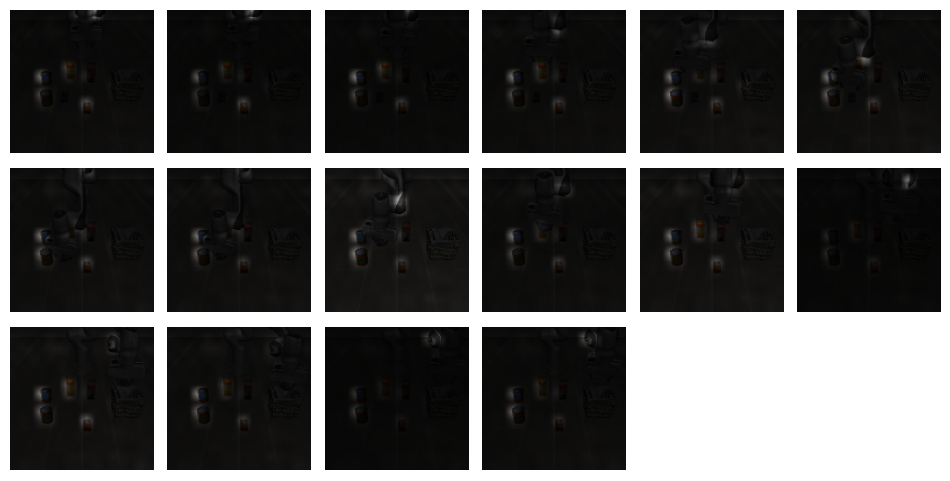

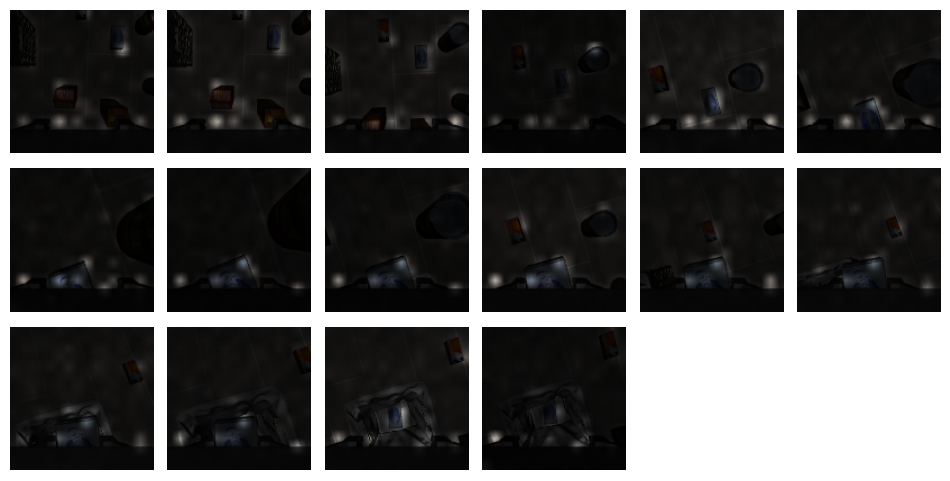

In [12]:
save_att_maps(task_id, traj_id)